Read in the necessary libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To achive an uniform appearance of all plots the 'darkgrid' template of seaborn is set as main visualization style
sns.set(style="darkgrid")

Read in the data to be analyzed

In [16]:
df_detailed_listings = pd.read_csv('./resource/detailed_listings.csv')

Prepping the data as in the Q1 Notebook:

In [17]:
df_listing_cleaned = df_detailed_listings.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', \
    'host_thumbnail_url', 'host_picture_url', 'latitude', 'longitude', 'calendar_updated', 'calendar_last_scraped', 'license'], 
    axis=1).copy()
df_listing_cleaned = df_listing_cleaned.dropna(axis=1, how='all')
df_listing_cleaned['price'] = df_listing_cleaned.price.str[1:].str.replace(',','').str.split('.').str[0].astype(int)

Question 3: How much are airbnb appartments earing in each neighboorhood over certain timeframes?

Therefore we prep the data as in the Q1 Notebook regarding the availability of listings over several timeframes. Then we invert these values to get the current bookings. We can not filter if the hosts did reserve their apartment for their own or blocked the availability for other reasons, but it should give a hint which neighborhoods are the most frequently booked ones and where do hosts make the most profit.

Gather all data of interest out of the main dataframe of all listings, filtered for listings that are marked as 'availale' through the column 'has_availality'.

In [18]:
df_analyze_q3 = df_listing_cleaned.loc[df_listing_cleaned['has_availability'] == 't',['neighbourhood_group_cleansed', 'price', 'availability_30', 'availability_60', 'availability_90', 'availability_365']].copy()

Filter some outliers:
- zero availality over the whole year
- listings where the availabilities for all three timeframes are the same (filter hosts who only open up booking for certain periods of time)

In [19]:
# filter for not listed apartments
df_analyze_q3 = df_analyze_q3[df_analyze_q3.availability_365 != 0].copy()

In [20]:
# filter for listings bookable only for certain periods of time
print(f'Listings only bookable for certain timeframes: {df_analyze_q3.query("availability_30 == availability_60 == availability_90 == availability_365").shape[0]}')
index = df_analyze_q3.query("availability_30 == availability_60 == availability_90 == availability_365").index
df_analyze_q3 = df_analyze_q3.drop(index=index, axis=0).copy()

Listings only bookable for certain timeframes: 572


For the days a listing is already booked we need to invert the availability over the given time frames.

In [21]:
df_analyze_q3['booked_30'] = 30 - df_analyze_q3.availability_30
df_analyze_q3['booked_60'] = 60 - df_analyze_q3.availability_60
df_analyze_q3['booked_90'] = 90 - df_analyze_q3.availability_90
df_analyze_q3['booked_365'] = 365 - df_analyze_q3.availability_365

And with the number of nights booked we can calculate how much revenue each listing is generating in regarding several timeframes

In [22]:
df_analyze_q3['revenue_30'] = df_analyze_q3.booked_30 * df_analyze_q3.price
df_analyze_q3['revenue_60'] = df_analyze_q3.booked_60 * df_analyze_q3.price
df_analyze_q3['revenue_90'] = df_analyze_q3.booked_90 * df_analyze_q3.price
df_analyze_q3['revenue_365'] = df_analyze_q3.booked_365 * df_analyze_q3.price

In [23]:
df_analyze_q3_agg = df_analyze_q3.groupby('neighbourhood_group_cleansed', as_index=False).aggregate(nights_booked=('booked_365', 'mean'), revenue=('revenue_365','mean'))

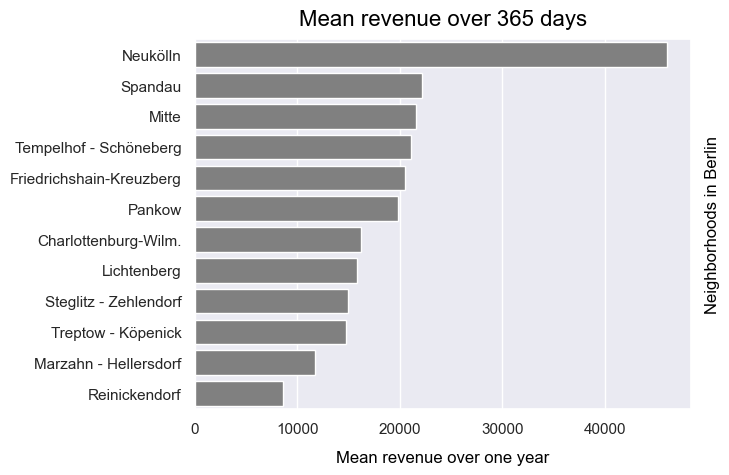

In [24]:
fig = sns.barplot(data=df_analyze_q3_agg.sort_values(by='revenue', ascending=False), x='revenue', y='neighbourhood_group_cleansed', ci=None, color='grey')

fig.set_title('Mean revenue over 365 days', pad=10, fontsize=16, color='black'); 
fig.set_xlabel('Mean revenue over one year', fontsize=12, color='black', labelpad=10);
fig.set_ylabel('Neighborhoods in Berlin', fontsize=12, color='black', labelpad=10);
fig.yaxis.set_label_position('right');

In [25]:
df_analyze_q3.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False)

neighbourhood_group_cleansed
Mitte                       203.292060
Neukölln                    201.233025
Spandau                     138.045872
Marzahn - Hellersdorf       129.690476
Tempelhof - Schöneberg      129.261824
Friedrichshain-Kreuzberg    121.371347
Pankow                      120.018883
Charlottenburg-Wilm.        114.692994
Treptow - Köpenick          110.809524
Steglitz - Zehlendorf       101.441860
Lichtenberg                  96.087963
Reinickendorf                72.081761
Name: price, dtype: float64